In [ ]:
#https://github.com/maxpumperla/elephas/blob/master/examples/ml_mlp_classification.py
#https://github.com/maxpumperla/elephas

In [1]:
!pip install pyspark --quiet
!pip install elephas --quiet

     |████████████████████████████████| 281.4 MB 44 kB/s 
     |████████████████████████████████| 199 kB 51.9 MB/s 
     |████████████████████████████████| 4.1 MB 9.8 MB/s 


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[6]").appName('Elephas_App').getOrCreate()
sc = spark.sparkContext

In [3]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

from elephas.ml_model import ElephasEstimator
from elephas.ml.adapter import to_data_frame

from pyspark import SparkContext, SparkConf
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline

In [4]:
# Define basic parameters
batch_size = 64
nb_classes = 10
epochs = 1

In [245]:
# Load data
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [237]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [246]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [247]:
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [248]:
print(y_train.shape)
print(y_test.shape)

(60000,)
(10000,)


In [249]:
nb_classes=10

In [250]:
%%time
# Convert class vectors to binary class matrices
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

CPU times: user 4.59 ms, sys: 0 ns, total: 4.59 ms
Wall time: 5.09 ms


In [251]:
from keras.models import Sequential

In [252]:
model = Sequential()
model.add(Dense(128, input_dim=784))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))

In [253]:
x_train.shape

(60000, 784)

In [254]:
%%time
# Build RDD from numpy features and labels
from elephas.ml.adapter import to_data_frame
df = to_data_frame(sc, x_train, y_train, categorical=True)
test_df = to_data_frame(sc, x_test, y_test, categorical=True)

Exception ignored in: <function JavaModelWrapper.__del__ at 0x7f8f306a8560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pyspark/mllib/common.py", line 152, in __del__
    assert self._sc._gateway is not None
AttributeError: 'MulticlassMetrics' object has no attribute '_sc'
/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


CPU times: user 1.89 s, sys: 2.06 s, total: 3.95 s
Wall time: 6.73 s


In [255]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
sgd_conf = optimizers.serialize(sgd)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [256]:
# Initialize Spark ML Estimator
estimator = ElephasEstimator()
estimator.set_keras_model_config(model.to_json())
estimator.set_optimizer_config(sgd_conf)
estimator.set_mode("synchronous")
estimator.set_loss("categorical_crossentropy")
estimator.set_metrics(['acc'])
estimator.set_epochs(epochs)
estimator.set_batch_size(batch_size)
estimator.set_validation_split(0.1)
estimator.set_categorical_labels(True)
estimator.set_nb_classes(nb_classes)

ElephasEstimator_f744f4e93d4f

In [ ]:
%%time
# Fitting a model returns a Transformer
pipeline = Pipeline(stages=[estimator])
fitted_pipeline = pipeline.fit(df)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/dataframe.py:149: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  "DataFrame.sql_ctx is an internal property, and will be removed "


>>> Fit model


In [ ]:
# Evaluate Spark model by evaluating the underlying model
predictions = fitted_pipeline.transform(test_df)
pnl = predictions.select("label", "prediction")

In [ ]:
%%time
pnl.show(100)

In [ ]:
%%time
#https://stackoverflow.com/questions/59951319/how-to-get-the-index-of-the-highest-value-in-a-list-per-row-in-a-spark-dataframe
import pyspark.sql.functions as f
from pyspark.sql.types import IntegerType, DoubleType
max_index = f.udf(lambda x: x.index(max(x)), IntegerType())

pnl = pnl.withColumn('max', max_index('prediction').cast(DoubleType()))
pnl.show(100)

In [ ]:
%%time
prediction_and_label = pnl.rdd.map(lambda row: (row.label, row.max))

In [ ]:
metrics = MulticlassMetrics(prediction_and_label)

In [ ]:
print("Accuracy:",metrics.accuracy)
print("Precision:",metrics.precision(1.0))
print("Recall:",metrics.recall(1.0))
print("F1Score:",metrics.fMeasure(1.0))

In [ ]:
%%time
df = pnl.toPandas()

In [ ]:
df.info()

In [ ]:
df.head()

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
%%time
y_true = pnl.select('label')
y_true = y_true.toPandas()
y_pred = pnl.select('max')
y_pred = y_pred.toPandas()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
import seaborn as sns

In [188]:
cm = confusion_matrix(y_true, y_pred)

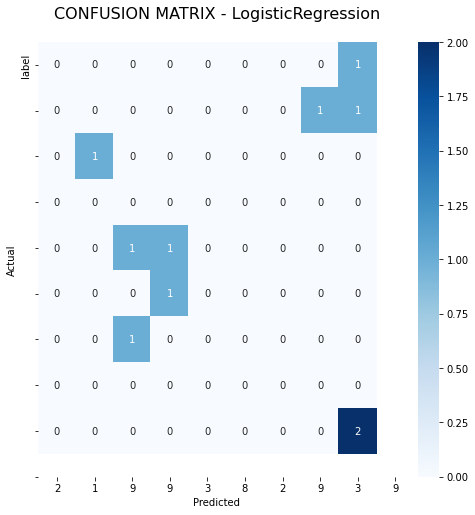

In [189]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d',
            xticklabels=y_pred, 
            yticklabels=y_true)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("CONFUSION MATRIX - LogisticRegression\n", size=16);

In [220]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.00      0.00      0.00         2
         2.0       0.00      0.00      0.00         1
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         2
         5.0       0.00      0.00      0.00         1
         7.0       0.00      0.00      0.00         1
         8.0       0.00      0.00      0.00         0
         9.0       0.50      1.00      0.67         2

    accuracy                           0.20        10
   macro avg       0.06      0.11      0.07        10
weighted avg       0.10      0.20      0.13        10



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1